<h1><center><strong>Lab Session 1: An Introduction to Textual Data</strong></center></h1>


# <font color="chillipepper">**Imports and Installation**</font>

In [ ]:
! pip3 install datasets

zsh:1: command not found: pip
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from operator import add
from termcolor import colored


# <font color="chillipepper">**Data Download**</font>

We will use the following databases:
1. [BBC News Classification dataset](https://www.kaggle.com/c/learn-ai-bbc/overview)
2. [Amazon Review dataset](https://huggingface.co/datasets/amazon_reviews_multi): a multilingual corpus that we will retrieve from the [Datasets](https://huggingface.co/datasets) library

In [2]:
! wget https://gitlab.com/gguibon/ensae-ml4nlp-storage/-/raw/master/bbc-news-data.zip
! unzip bbc-news-data.zip

--2025-09-01 14:12:57--  https://gitlab.com/gguibon/ensae-ml4nlp-storage/-/raw/master/bbc-news-data.zip
Resolving gitlab.com (gitlab.com)... 172.65.251.78
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1896286 (1.8M) [application/octet-stream]
Saving to: ‘bbc-news-data.zip’

bbc-news-data.zip   100%[===================>]   1.81M  2.76MB/s    in 0.7s    

2025-09-01 14:12:58 (2.76 MB/s) - ‘bbc-news-data.zip’ saved [1896286/1896286]

Archive:  bbc-news-data.zip
  inflating: bbc-news-data.csv       


# <font color="chillipepper">**Data Basic Exploration**</font>

We first start by opening the database and load it as a **Pandas dataframe**.

In [3]:
df = pd.read_csv('./bbc-news-data.csv', sep='\t')
print("Shape:  {0}".format(df.shape))
df.head()

Shape:  (2225, 4)


,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


Our dataframe have the following columns:

In [4]:
df.columns

Index(['category', 'filename', 'title', 'content'], dtype='object')

###  Print the number of different articles in the database.



In [5]:
# Number of different articles in the database
print(len(df.filename.unique()))

511


### print the mean length (*i.e.* number of characters) of the `content` column

In [6]:
# Mean length of content in characters
df.content.drop_duplicates().apply(len).mean()

2232.1692160611856

### display the different article categories as a list

In [7]:
# display the different article categories
df.category.drop_duplicates().tolist()

['business', 'entertainment', 'politics', 'sport', 'tech']

### display the number of articles per `category`.

In [8]:
# We check the number of article per category
df.drop_duplicates().groupby(df.category).size()

category
business         510
entertainment    386
politics         417
sport            511
tech             401
dtype: int64

### Let's add some basic information about the text: number of "words". Put them into new `title_len` and `content_len` columns. 

In [9]:
# let's add some basic information about the text: number of "words" (here we only split by a space, a really naive approach)
df['title_len'] = df.title.apply(lambda x: len(x.split(' ')) )
df['content_len'] = df.content.apply(lambda x: len(x.split(' ')) )

# <font color="chillipepper">**Word-level Preprocessing**</font>

### Split the abstracts into list of words using three different tokenizers from nltk. What is the difference in terms of number of words? What do you think has changed?

In [10]:
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import ToktokTokenizer
from nltk.tokenize import TweetTokenizer
from tqdm.notebook import tqdm

tokenizers = [TreebankWordTokenizer(), ToktokTokenizer(), TweetTokenizer()]
import pdb # python debugger
for tok in tqdm(tokenizers):
  print('Using tokenizer: %s' % (tok))
  arr = df.content.drop_duplicates().apply(lambda x: tok.tokenize(x)).array
  # We flatten the list. 
  arr = [ x for X in arr for x in X]
  # the set object transforms a list to the set of unique elements in the list :
  print('The 30 first tokens: %s' % (arr[:30]) )
  print("Vocabulary size: {0} with {1} tokenizer".format(len(set(arr)), tok))
  print('='*5)  

  0%|          | 0/3 [00:00<?, ?it/s]

Using tokenizer: <nltk.tokenize.treebank.TreebankWordTokenizer object at 0x12c02f340>
The 30 first tokens: ['Quarterly', 'profits', 'at', 'US', 'media', 'giant', 'TimeWarner', 'jumped', '76', '%', 'to', '$', '1.13bn', '(', '£600m', ')', 'for', 'the', 'three', 'months', 'to', 'December', ',', 'from', '$', '639m', 'year-earlier.', 'The', 'firm', ',']
Vocabulary size: 45705 with <nltk.tokenize.treebank.TreebankWordTokenizer object at 0x12c02f340> tokenizer
=====
Using tokenizer: <nltk.tokenize.toktok.ToktokTokenizer object at 0x12c02feb0>
The 30 first tokens: ['Quarterly', 'profits', 'at', 'US', 'media', 'giant', 'TimeWarner', 'jumped', '76', '%', 'to', '$', '1.13bn', '(', '£', '600m', ')', 'for', 'the', 'three', 'months', 'to', 'December', ',', 'from', '$', '639m', 'year-earlier.', 'The', 'firm']
Vocabulary size: 45295 with <nltk.tokenize.toktok.ToktokTokenizer object at 0x12c02feb0> tokenizer
=====
Using tokenizer: <nltk.tokenize.casual.TweetTokenizer object at 0x12c02fe50>
The 30 first

If you look at the first 30 tokens, the `TweetTokenizer` is the only one to separate "bn" from "1.13" in "1.13bn".

### Check if Zipf's law applies.

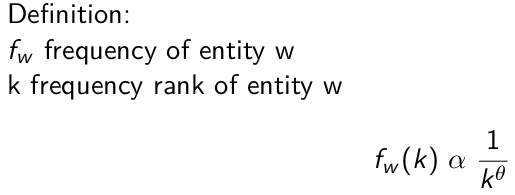

  0%|          | 0/3 [00:00<?, ?it/s]

Counter({'the': 41922, ',': 33355, 'to': 23016, 'of': 18551, 'and': 16858, 'a': 16227, 'in': 15506, '``': 10530, "''": 8756, "'s": 8327, 'is': 8040, 'for': 7949, 'The': 7494, 'that': 7278, 'on': 6681, 'was': 5755, 'said': 5475, 'be': 5359, 'it': 5203, 'with': 4766, 'has': 4674, 'have': 4495, 'as': 4330, 'at': 4112, 'will': 4104, 'he': 4097, 'by': 4066, 'are': 4062, 'I': 3695, '.': 3547, 'not': 3342, 'from': 3242, '-': 3009, 'Mr': 2796, 'his': 2687, 'an': 2544, 'but': 2507, 'would': 2458, 'had': 2447, 'which': 2407, 'been': 2346, 'they': 2323, 'their': 2203, ')': 2114, '(': 2112, 'were': 2066, 'this': 2055, 'its': 2045, 'more': 1987, 'also': 1955, 'It': 1940, 'who': 1935, '%': 1837, 'we': 1790, 'up': 1739, 'people': 1691, 'But': 1690, 'about': 1639, ':': 1568, 'can': 1558, 'He': 1500, 'than': 1499, 'or': 1498, 'after': 1488, 'could': 1431, 'out': 1391, 'one': 1356, 'new': 1353, 'said.': 1328, 'US': 1311, 'year': 1290, 'all': 1234, 'over': 1215, 'do': 1201, 'you': 1177, 'there': 1171, 'l

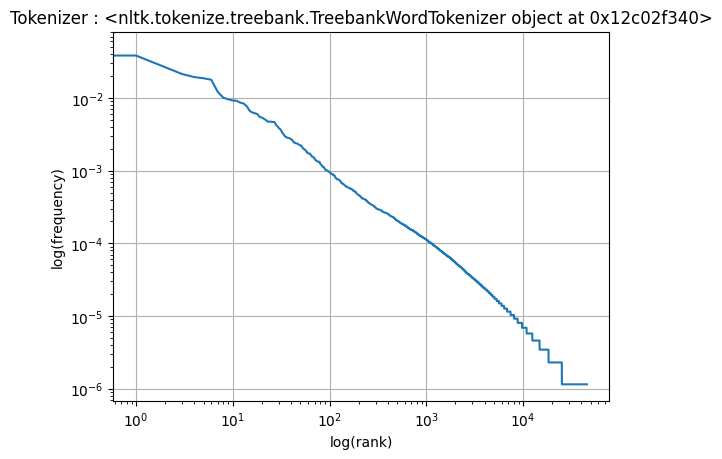

Counter({'the': 41925, ',': 33355, 'to': 23014, '"': 19265, 'of': 18551, 'and': 16858, 'a': 16234, 'in': 15505, "'": 12332, 's': 8329, 'is': 7982, 'for': 7947, 'The': 7496, 'that': 7279, 'on': 6681, 'was': 5693, 'said': 5392, 'be': 5361, 'it': 5200, 'with': 4766, 'has': 4656, 'have': 4451, 'as': 4330, 'at': 4112, 'will': 4105, 'he': 4097, 'by': 4067, 'are': 4042, 'I': 3714, 'from': 3241, 'not': 3182, '-': 3009, 'Mr': 2796, 'his': 2687, 'an': 2545, 'but': 2507, 'had': 2440, 'which': 2407, 'would': 2407, 'been': 2346, 'they': 2323, 'their': 2203, ')': 2114, '(': 2112, '.': 2061, 'this': 2055, 'were': 2050, 'its': 2045, 'more': 1985, 'also': 1955, 'It': 1940, 'who': 1936, '%': 1837, 'we': 1791, 'up': 1740, 'people': 1691, 'But': 1690, 'about': 1639, ':': 1596, 'can': 1523, 'He': 1500, 'than': 1499, 'or': 1499, 'after': 1487, 'said.': 1411, 'could': 1397, 'out': 1389, 'one': 1357, 'new': 1354, '£': 1305, 'US': 1297, 'year': 1267, 'all': 1235, 'over': 1215, 'you': 1181, 'there': 1169, 'last

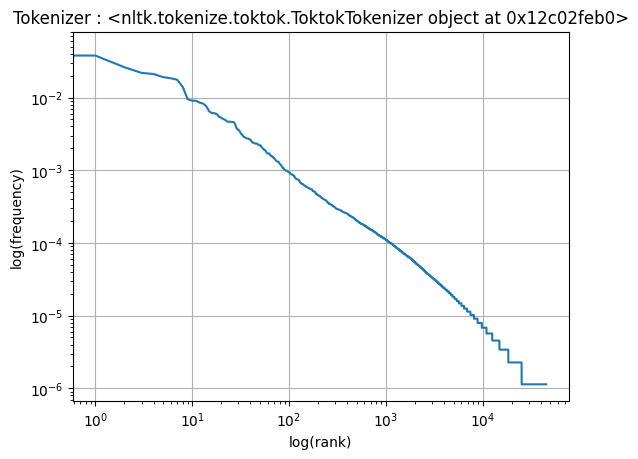

Counter({'the': 41925, '.': 38402, ',': 33363, 'to': 23041, '"': 19265, 'of': 18557, 'and': 16869, 'a': 16233, 'in': 15552, 'is': 8017, 'for': 7973, 'The': 7500, 'that': 7247, 'said': 6803, 'on': 6739, 'was': 5701, 'be': 5389, 'it': 5058, 'with': 4789, 'has': 4658, 'have': 4456, 'as': 4330, 'at': 4116, 'will': 4115, 'by': 4071, 'are': 4055, 'he': 3999, '-': 3616, 'from': 3250, 'not': 3209, 'I': 3096, 'Mr': 2806, 'his': 2691, 'an': 2545, 'but': 2507, 'had': 2448, 'would': 2410, 'which': 2408, 'been': 2348, 'they': 2250, 'their': 2203, 'this': 2100, '(': 2095, ')': 2076, 'were': 2058, 'its': 2045, 'more': 2015, 'also': 1956, 'who': 1930, '%': 1837, 'up': 1794, 'people': 1691, 'But': 1690, 'about': 1654, 'we': 1629, ':': 1563, "'": 1541, 'It': 1521, 'or': 1508, 'than': 1499, 'after': 1489, 'year': 1487, 'out': 1472, 'He': 1454, 'can': 1410, 'could': 1398, 'one': 1393, 'US': 1379, 'new': 1358, '£': 1306, 'all': 1269, 'over': 1249, 'last': 1165, 'there': 1162, 'first': 1156, '$': 1148, 'you

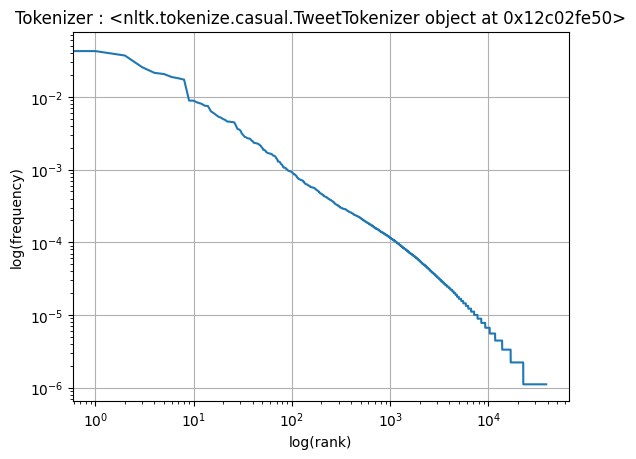

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

for tok in tqdm(tokenizers):
  arr = df.content.drop_duplicates().apply(lambda x: tok.tokenize(x)).array
  # We flatten the list. We could use this : arr = reduce(add, arr)   but it would take too much time.
  arr = [ x for X in arr for x in X]
  # We use reduce to concatenate all the lists in arr, but we don't use "set" 
  # so that we can count occurencies with a Counter object 
  c = Counter(arr)
  print(c)
  # Formating the counter object to a proper dataset
  d = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
  d.columns=['word', 'occurences']
  # Computing frequencies instead of occurences
  nb_total = d.occurences.sum()
  d['freq'] = d.occurences.apply(lambda x: x/nb_total)
  # Sorting by frequency, most frequent word at the top of the df
  d = d.sort_values('freq', ascending=False)
  plt.figure()
  plt.grid()
  plt.xscale('log')  # Using log scale
  plt.yscale('log')  # Using log scale
  plt.xlabel('log(rank)')
  plt.ylabel('log(frequency)')
  plt.title("Tokenizer : {0}".format(tok))
  x = list(range(d.shape[0]))
  plt.plot(x, d.freq)
  plt.show()


# <font color="chillipepper">**Classic NLP pipeline**</font>


0. Re-tokenize using spacy

1. Lemmatize using spacy

2. POS tagging using spacy, plot the trees

3. NER using spacy, give the amount of each entity type for a given title, and compare it to the title length. 

### Re-tokenize using spacy

It is useful to take a look at spacy's [tokenizer documentation](https://spacy.io/usage/spacy-101#annotations-token)

In [13]:
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()

# Instanciating the tokenizer
tokenizer = Tokenizer(nlp.vocab)

# Repeating the earlier vocabulary count
arr = df.content.drop_duplicates().apply(lambda x: tok.tokenize(x)).array
arr = [ x for X in arr for x in X]
print("Vocabulary size with Spacy's tokenizer: {}".format(len(set(arr))))

# Inspecting a tokenization sample
tokenization_sample = df.title.head().apply(lambda x: 
                                              [w.text for w in tokenizer(x)])
print("Tokenization sample:\n {}".format(tokenization_sample))

Vocabulary size with Spacy's tokenizer: 38748
Tokenization sample:
 0    [Ad, sales, boost, Time, Warner, profit]
1      [Dollar, gains, on, Greenspan, speech]
2    [Yukos, unit, buyer, faces, loan, claim]
3    [High, fuel, prices, hit, BA's, profits]
4     [Pernod, takeover, talk, lifts, Domecq]
Name: title, dtype: object


The tokenizer doesn't seem to do better than nltk's tokenizers, in terms of vocabulary size.


### Lemmatize using spacy

In [90]:
!python3 -m spacy download en_core_web_sm

/Users/inesmac/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 12.8 MB 262 kB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [14]:
import spacy
from spacy.lookups import Lookups

nlp = spacy.load("en_core_web_sm")

# Counting lemmas vocabulary count
arr = df.title.apply(lambda x: [w.lemma_ for w in nlp(x)]).array
arr = [ x for X in arr for x in X]
print("Number of unique lemmas found with Spacy's lemmatizer: {}".format(len(set(arr))))

lemmatization_sample = df.title.head().apply(lambda x: 
                                              [w.lemma_ for w in nlp(x)])
print("Lemmatization sample:\n {}".format(lemmatization_sample))

Number of unique lemmas found with Spacy's lemmatizer: 3468
Lemmatization sample:
 0     [ad, sale, boost, Time, Warner, profit]
1       [dollar, gain, on, Greenspan, speech]
2     [Yukos, unit, buyer, face, loan, claim]
3    [high, fuel, price, hit, BA, 's, profit]
4      [pernod, takeover, talk, lift, domecq]
Name: title, dtype: object


In [16]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

stemming_sample = df.title.head().apply(lambda x: [stemmer.stem(w.text) for w in nlp(x)])

print("Stemming sample:\n {}".format(stemming_sample))

Stemming sample:
 0     [ad, sale, boost, time, warner, profit]
1       [dollar, gain, on, greenspan, speech]
2      [yuko, unit, buyer, face, loan, claim]
3    [high, fuel, price, hit, ba, 's, profit]
4        [pernod, takeov, talk, lift, domecq]
Name: title, dtype: object


### POS tagging using spacy, plot the trees

In [17]:
from spacy import displacy

# Inspecting a dependency tree and it's POS TAGs wth displacy
for title in df.title.head()[:2]:
  doc = nlp(title)
  displacy.render(doc, style="dep", jupyter=True)



### NER using spacy, give the amount of each entity type for a given abstract, and compare it to the amount of citations. 

In [18]:
# Visualizing Entities
for title in df.title[:10]:
  doc = nlp(title)
  displacy.render(doc, style="ent",jupyter=True)

### Get the entity Information and display the available entity types

In [19]:
# Getting the entity Information (takes about 40s)
short_df = df[['title', 'title_len']]
title_ent = short_df['title'].apply(lambda x: [ent.label_ for ent in nlp(x).ents]).array

# Displaying the available entity types
ent_types = set(np.concatenate(title_ent))
print("Spacy recognizes {} entity types. "
"These types are the following:\n{}".format(len(ent_types), ent_types))


Spacy recognizes 16 entity types. These types are the following:
{'GPE', 'WORK_OF_ART', 'DATE', 'PERCENT', 'LAW', 'MONEY', 'LOC', 'TIME', 'NORP', 'PERSON', 'CARDINAL', 'EVENT', 'ORG', 'PRODUCT', 'ORDINAL', 'FAC'}


### Getting counts for Every entity type

In [22]:
# Getting counts for Every entity type
for ent_type in ent_types:
  ent_count = [sum([title_ent_ij==ent_type for title_ent_ij in title_ent_i])
  for title_ent_i in title_ent]
  short_df[ent_type] = ent_count

short_df[list(ent_types)].head()

,GPE,WORK_OF_ART,DATE,PERCENT,LAW,MONEY,LOC,TIME,NORP,PERSON,CARDINAL,EVENT,ORG,PRODUCT,ORDINAL,FAC
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
